### Key Challenge in this Task:
Importing large data sets is a hassle here. Each one of train and test data sets is of size 5GB+. We have used [Dask Dataframe](https://docs.dask.org/en/latest/dataframe.html) to tackle this challenge. [Dask](https://dask.org/) provides a framework to scale pandas workflows natively using a parallel processing architecture.



### List of Acknowledgements :
* **Acknowledgement 1:** [Theo Viel's data loading work](https://www.kaggle.com/theoviel/load-the-totality-of-the-data) but I have made some modifications
* **Acknowledgement 2:** Memory optimization explanation from [Chris Deotte](https://www.kaggle.com/cdeotte) (Each column in train.csv has 9 million rows. If we declare that column as int16 then we allocate 2 bytes per each row equaling 18 million bytes for that column. Instead, if we declare that column as int8 we allocate 1 byte per each row equaling 9 million bytes).
* **Acknowledgement 3:** [Fabien Daniel's brilliant work using LGBM](https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm) where he used a census of variables: binary, true numericals (floats) and categorical.

# 1. Import Necessary library

In [1]:
import dask
import dask.dataframe as dd
import warnings
import numpy as np
import pandas as pd
import gc
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.feature_selection import SelectKBest,f_classif


%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.svm import SVC
import tensorflow as tf

In [4]:
#!pip install --upgrade ipython

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function() {
    return False;
}

<IPython.core.display.Javascript object>

In [6]:
# Taken from https://www.kaggle.com/theoviel/load-the-totality-of-the-data
# I modified some data types

dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [7]:
# We will use this quite often to clear memory space
gc.collect()

62

**Import full dataset using dask**

In [8]:
df = dd.read_csv("../input/microsoft-malware-prediction/train.csv", dtype=dtypes) 
df = df.compute()

In [9]:
gc.collect()

20

In [10]:
df.isnull().sum()

MachineIdentifier                               0
ProductName                                     0
EngineVersion                                   0
AppVersion                                      0
AvSigVersion                                    0
                                            ...  
Census_IsPenCapable                             0
Census_IsAlwaysOnAlwaysConnectedCapable     71343
Wdft_IsGamer                               303451
Wdft_RegionIdentifier                      303451
HasDetections                                   0
Length: 83, dtype: int64

# 2. Every column label encoding

**#we will apply ONE-HOT-ENCODE only for two level**

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
CV = CountVectorizer()
Lab=LabelEncoder()
for columns in df.columns:
  if df[columns].dtype=='<U17':
    df[columns]=CV.fit_transform(df[columns])
  elif df[columns].dtype=='<U3':
      df[columns]=Lab.fit_transform(df[columns])

In [13]:
for columns in df.columns:
    if df[columns].dtype=='int64':
     df[columns]=Lab.fit_transform(df[columns])


In [14]:
df

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67082,ffffedfe8fcc46e6d36ab39953589fee,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1555.0,0,7.0,0,NaN,53447.0,...,63069.0,1,NaN,0.0,0,0,0.0,0.0,5.0,1
67083,ffffef606490b2970873ec0a27ebd24b,win8defender,1.1.13303.0,4.9.10586.672,1.233.4218.0,0,7.0,0,1078.0,59914.0,...,NaN,0,0.0,0.0,0,0,0.0,0.0,5.0,0
67084,fffff8a40070d2d8379bb7fa2ed2fa66,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1242.0,0,7.0,0,NaN,53447.0,...,71061.0,1,NaN,0.0,0,0,0.0,0.0,7.0,1
67085,fffffbbaaf5969ae4b93e7f3f6d7132f,win8defender,1.1.14901.4,4.16.17656.18052,1.269.1834.0,0,7.0,0,NaN,6630.0,...,33142.0,1,NaN,0.0,0,0,0.0,0.0,13.0,1


**Last**


**Convert all columns**

**Columns with High Cardinality: 10 columns**

['AvSigVersion',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'CityIdentifier',
 'OsBuildLab',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier']

In [15]:
df['AvSigVersion'].value_counts()

1.273.1420.0    102317
1.263.48.0       98024
1.275.1140.0     97232
1.275.727.0      92448
1.273.371.0      86967
                 ...  
1.219.1500.0         1
1.223.927.0          1
1.223.2658.0         1
1.221.745.0          1
1.223.1075.0         1
Name: AvSigVersion, Length: 8531, dtype: int64

In [16]:
#df['EngineVersion']=[str(i) for i in df['EngineVersion']]
df['AvSigVersion']=Lab.fit_transform(df['AvSigVersion'])

In [17]:
df['AvSigVersion'].value_counts()

7694    102317
6303     98024
8048     97232
8412     92448
7856     86967
         ...  
103          1
104          1
361          1
105          1
85           1
Name: AvSigVersion, Length: 8531, dtype: int64

In [18]:
df['DefaultBrowsersIdentifier'].value_counts()

239.0     46056
3196.0    42694
1632.0    28751
3176.0    24222
146.0     20756
          ...  
881.0         1
1885.0        1
1886.0        1
877.0         1
1370.0        1
Name: DefaultBrowsersIdentifier, Length: 1730, dtype: int64

In [19]:
df['AVProductStatesIdentifier'].value_counts()

53447.0    5824565
7945.0      475897
47238.0     327656
62773.0     266764
46413.0     112878
            ...   
39357.0          1
39358.0          1
39360.0          1
39366.0          1
3.0              1
Name: AVProductStatesIdentifier, Length: 28970, dtype: int64

In [20]:
df['CityIdentifier'].value_counts()

130775.0    94812
16668.0     84780
82373.0     83312
10222.0     71814
61668.0     66845
            ...  
83680.0         1
83670.0         1
83653.0         1
34678.0         1
128879.0        1
Name: CityIdentifier, Length: 107366, dtype: int64

In [21]:
df['OsBuildLab'].value_counts()

17134.1.amd64fre.rs4_release.180410-1804                    3658199
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908       1252674
16299.15.amd64fre.rs3_release.170928-1534                    961060
15063.0.amd64fre.rs2_release.170317-1834                     718033
17134.1.x86fre.rs4_release.180410-1804                       257074
                                                             ...   
14393.1797.amd64fre.rs1_release_inmarket_aim.171027-1738          1
7600.16905.x86fre.win7_gdr.111025-1503                            1
7600.20941.x86fre.win7_ldr.110408-1635                            1
14298.1944.amd64fre.rs1_release.171132-2100                       1
17750.1000.amd64fre.rs5_release.180827-1459                       1
Name: OsBuildLab, Length: 663, dtype: int64

In [22]:
df['OsBuildLab']=[str(i) for i in df['OsBuildLab']]
df['OsBuildLab']=Lab.fit_transform(df['OsBuildLab'])

In [23]:
df['OsBuildLab'].value_counts()

272    3658199
261    1252674
257     961060
252     718033
274     257074
        ...   
568          1
425          1
428          1
178          1
336          1
Name: OsBuildLab, Length: 664, dtype: int64

In [24]:
df['Census_OEMNameIdentifier'].value_counts()

2668.0    1287276
2102.0    1038567
1443.0     949531
2206.0     924349
585.0      895452
           ...   
916.0           1
2490.0          1
2492.0          1
2498.0          1
2.0             1
Name: Census_OEMNameIdentifier, Length: 2564, dtype: int64

In [25]:
df['Census_OEMModelIdentifier'].value_counts()

313586.0    304782
242491.0    263382
317701.0    139035
317708.0    115257
228975.0     79878
             ...  
177414.0         1
177419.0         1
177422.0         1
177424.0         1
3.0              1
Name: Census_OEMModelIdentifier, Length: 175365, dtype: int64

In [26]:
df['Census_ProcessorModelIdentifier'].value_counts()

2696.0    289284
1998.0    267397
2660.0    195737
2372.0    175412
1992.0    171728
           ...  
1202.0         1
1201.0         1
1200.0         1
1199.0         1
2.0            1
Name: Census_ProcessorModelIdentifier, Length: 2583, dtype: int64

In [27]:
df['Census_FirmwareManufacturerIdentifier'].value_counts()

142.0    2699078
628.0    1229140
554.0    1175137
355.0     941793
556.0     800536
          ...   
470.0          1
469.0          1
462.0          1
459.0          1
2.0            1
Name: Census_FirmwareManufacturerIdentifier, Length: 712, dtype: int64

In [28]:
df['Census_FirmwareVersionIdentifier'].value_counts()

33105.0    89611
33111.0    61583
33054.0    56626
33108.0    55040
11778.0    53785
           ...  
32032.0        1
32031.0        1
32030.0        1
32028.0        1
3.0            1
Name: Census_FirmwareVersionIdentifier, Length: 50494, dtype: int64

**Columns with > 40% Missing Values: 6 columns**

['PuaMode',
 'Census_ProcessorClass',
 'Census_InternalBatteryType',
 'Census_IsFlightingInternal',
 'Census_ThresholdOptIn',
 'Census_IsWIMBootEnabled']**

In [29]:
df['PuaMode'].value_counts()

on       2307
audit       2
Name: PuaMode, dtype: int64

In [30]:

df['PuaMode']=pd.get_dummies(df['PuaMode'],drop_first=True)

In [31]:
df['PuaMode']=[str(i) for i in df['PuaMode']]
df['PuaMode']=Lab.fit_transform(df['PuaMode'])

In [32]:
df['PuaMode'].value_counts()

0    8921481
1          2
Name: PuaMode, dtype: int64

In [33]:
df['Census_ProcessorClass'].value_counts()

mid     20914
low      9621
high     6096
Name: Census_ProcessorClass, dtype: int64

In [34]:
df['Census_ProcessorClass']=[str(i) for i in df['Census_ProcessorClass']]
df['Census_ProcessorClass']=Lab.fit_transform(df['Census_ProcessorClass'])

In [35]:
df['Census_ProcessorClass'].value_counts()

3    8884852
2      20914
1       9621
0       6096
Name: Census_ProcessorClass, dtype: int64

In [36]:
df['Census_InternalBatteryType'].value_counts()

lion    2028256
li-i     245617
#        183998
lip       62099
liio      32635
         ...   
sail          1
p-sn          1
a130          1
2337          1
lÿÿÿ          1
Name: Census_InternalBatteryType, Length: 78, dtype: int64

In [37]:
df['Census_InternalBatteryType']=[str(i) for i in df['Census_InternalBatteryType']]
df['Census_InternalBatteryType']=Lab.fit_transform(df['Census_InternalBatteryType'])

In [38]:
df['Census_InternalBatteryType'].value_counts()

61    6338429
52    2028256
45     245617
4      183998
53      62099
       ...   
28          1
27          1
60          1
64          1
0           1
Name: Census_InternalBatteryType, Length: 79, dtype: int64

In [39]:
df['Census_IsFlightingInternal'].value_counts()

0.0    1512703
1.0         21
Name: Census_IsFlightingInternal, dtype: int64

In [40]:
df['Census_ThresholdOptIn'].value_counts()

0.0    3253342
1.0        816
Name: Census_ThresholdOptIn, dtype: int64

In [41]:
df['Census_IsWIMBootEnabled'].value_counts()

0.0    3261779
1.0          1
Name: Census_IsWIMBootEnabled, dtype: int64

***Removing Unnecessary Columns : 'MachineIdentifier' 1 columnn ***

In [42]:
df['MachineIdentifier'].value_counts()

ffffff75ba4f33d938ccfdb148b8ea16    1
555230d9125241ea09d2964cab0dde73    1
5552388719990067c5d69db11a0be3d6    1
5552378fba13284141c48d06d26fb303    1
555236649a01545c9f0ded3dcfc14458    1
                                   ..
aab3df149ba01dd1f3e988e39cd884b7    1
aab3e65d0054f5eeb8d4370cfabfb04d    1
aab3e6d03bbe17e8c1abdcab9009421e    1
aab3e7fdf613e9a9b516783546c0d3e0    1
0000028988387b115f69f31a3bf04f09    1
Name: MachineIdentifier, Length: 8921483, dtype: int64

In [43]:
#df['Census_InternalBatteryType']=[str(i) for i in df['Census_InternalBatteryType']]
df['MachineIdentifier']=Lab.fit_transform(df['MachineIdentifier'])

In [44]:
df['MachineIdentifier'].value_counts()

8392702    1
6563374    1
6587962    1
2420279    1
6612534    1
          ..
6584794    1
2388443    1
6576606    1
2380255    1
0          1
Name: MachineIdentifier, Length: 8921483, dtype: int64

**Done 17**

In [45]:
gc.collect()

240

Encoders require their input to be uniformly strings or numbers. Got ['float', 'str']
1. SmartScreen
2. Census_PrimaryDiskTypeName
3. Census_ChassisTypeName
4. Census_PowerPlatformRoleName

In [46]:
df['SmartScreen']=[str(i) for i in df['SmartScreen']]
df['SmartScreen']=Lab.fit_transform(df['SmartScreen'])

In [47]:
df['SmartScreen'].value_counts()

13    4316183
15    3177011
7     1046183
9      186553
14     135483
11      34533
5       22533
16       1350
10        731
1         416
0         335
17        147
20         10
8           4
3           3
12          2
6           1
18          1
4           1
2           1
19          1
21          1
Name: SmartScreen, dtype: int64

In [48]:
df['Census_PrimaryDiskTypeName']=[str(i) for i in df['Census_PrimaryDiskTypeName']]
df['Census_PrimaryDiskTypeName']=Lab.fit_transform(df['Census_PrimaryDiskTypeName'])

In [49]:
df['Census_PrimaryDiskTypeName'].value_counts()

0    5806804
1    2466808
2     358251
3     276776
4      12844
Name: Census_PrimaryDiskTypeName, dtype: int64

In [50]:
df['Census_ChassisTypeName']=[str(i) for i in df['Census_ChassisTypeName']]
df['Census_ChassisTypeName']=Lab.fit_transform(df['Census_ChassisTypeName'])

In [51]:
df['Census_ChassisTypeName'].value_counts()

38    5248812
24    1872125
31     685581
41     360903
18     204295
36      85127
23      84472
39      75782
50      67212
25      51466
32      50072
29      46009
44      29070
48      13630
49      12549
51      10011
34       9545
35       4433
33       3971
42       3410
47        807
21        720
52        623
5         243
45        142
0         133
37         61
19         52
8          50
40         46
43         39
46         16
28         12
6          11
7           8
17          8
2           7
3           6
11          4
9           3
15          2
20          2
22          2
26          2
4           1
1           1
27          1
10          1
12          1
14          1
16          1
30          1
13          1
Name: Census_ChassisTypeName, dtype: int64

In [52]:
df['Census_PowerPlatformRoleName']=[str(i) for i in df['Census_PowerPlatformRoleName']]
df['Census_PowerPlatformRoleName']=Lab.fit_transform(df['Census_PowerPlatformRoleName'])

In [53]:
df['Census_PowerPlatformRoleName'].value_counts()

3     6182908
1     2066620
6      492537
9      109683
5       37841
7       20628
2        7094
0        4015
4          97
10         55
8           5
Name: Census_PowerPlatformRoleName, dtype: int64

**Done 4.  17+4 = 21**

In [54]:

#print(df.shape)
#df.head()

**Next 62**

In [55]:
df['ProductName'].value_counts()

win8defender     8826520
mse                94873
mseprerelease         53
scep                  22
windowsintune          8
fep                    7
Name: ProductName, dtype: int64

In [56]:
df['ProductName']=Lab.fit_transform(df['ProductName'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [57]:
df['ProductName'].value_counts()

4    8826520
1      94873
2         53
3         22
5          8
0          7
Name: ProductName, dtype: int64

In [58]:
df['EngineVersion'].value_counts()


1.1.15200.1    3845067
1.1.15100.1    3675915
1.1.15000.2     265218
1.1.14901.4     212408
1.1.14600.4     160585
                ...   
1.1.13301.0          2
1.1.12802.0          1
1.1.11202.0          1
1.1.11104.0          1
1.1.10701.0          1
Name: EngineVersion, Length: 70, dtype: int64

In [59]:
df['EngineVersion']=[str(i) for i in df['EngineVersion']]
df['EngineVersion']=Lab.fit_transform(df['EngineVersion'])

In [60]:
df['EngineVersion'].value_counts()


66    3845067
65    3675915
64     265218
62     212408
55     160585
       ...   
31          2
19          1
4           1
3           1
2           1
Name: EngineVersion, Length: 70, dtype: int64

In [61]:
df['AppVersion'].value_counts()

4.18.1807.18075    5139224
4.18.1806.18062     850929
4.12.16299.15       359871
4.10.209.0          272455
4.13.17134.1        257270
                    ...   
4.8.10240.17943          1
4.5.212.0                1
4.13.17134.226           1
4.7.209.0                1
4.13.17604.1000          1
Name: AppVersion, Length: 110, dtype: int64

In [62]:
df['AppVersion']=[str(i) for i in df['AppVersion']]
df['AppVersion']=Lab.fit_transform(df['AppVersion'])

In [63]:
df['AppVersion'].value_counts()

59    5139224
53     850929
20     359871
13     272455
26     257270
       ...   
64          1
69          1
90          1
92          1
29          1
Name: AppVersion, Length: 110, dtype: int64

In [64]:
df['IsBeta'].value_counts()

0    8921416
1         67
Name: IsBeta, dtype: int64

In [65]:
df['RtpStateBitfield'].value_counts()

7.0     8651487
0.0      190701
8.0       21974
5.0       20328
3.0        3029
1.0        1625
35.0         21
Name: RtpStateBitfield, dtype: int64

In [66]:
df['IsSxsPassiveMode'].value_counts()

0    8766840
1     154643
Name: IsSxsPassiveMode, dtype: int64

In [67]:
df['AVProductsInstalled'].value_counts()

1.0    6208893
2.0    2459008
3.0     208103
4.0       8757
5.0        471
6.0         28
7.0          1
0.0          1
Name: AVProductsInstalled, dtype: int64

In [68]:
df['AVProductsEnabled'].value_counts()

1.0    8654101
2.0     198652
0.0      25958
3.0       6075
4.0        453
5.0         23
Name: AVProductsEnabled, dtype: int64

In [69]:
df['HasTpm'].value_counts()

1    8814167
0     107316
Name: HasTpm, dtype: int64

In [70]:
df['CountryIdentifier'].value_counts()

43     397172
29     347991
141    333411
93     283625
171    280572
        ...  
165       213
37        212
193       207
161       206
217       120
Name: CountryIdentifier, Length: 222, dtype: int64

In [71]:
df['OrganizationIdentifier'].value_counts()

27.0    4196457
18.0    1764175
48.0      63845
50.0      45502
11.0      19436
37.0      19398
49.0      13627
46.0      10974
14.0       4713
32.0       4045
36.0       3909
52.0       3043
33.0       2896
2.0        2595
5.0        1990
40.0       1648
28.0       1591
4.0        1385
10.0       1083
51.0        917
20.0        915
1.0         893
8.0         723
22.0        418
39.0        413
6.0         412
31.0        398
21.0        397
47.0        385
3.0         331
16.0        242
19.0        172
26.0        160
44.0        150
29.0        135
42.0        132
7.0          98
41.0         77
45.0         73
30.0         64
43.0         60
35.0         32
23.0         20
15.0         13
25.0         12
12.0          7
34.0          2
38.0          1
17.0          1
Name: OrganizationIdentifier, dtype: int64

In [72]:
df['GeoNameIdentifier'].value_counts()

277.0    1531929
211.0     423166
53.0      408807
89.0      360798
240.0     346568
          ...   
13.0           1
14.0           1
197.0          1
279.0          1
132.0          1
Name: GeoNameIdentifier, Length: 292, dtype: int64

In [73]:
df['LocaleEnglishNameIdentifier'].value_counts()

 75     2094585
-74      450088
 74      411056
 42      409616
 88      375223
         ...   
 99           3
 39           2
-103          2
-65           1
-53           1
Name: LocaleEnglishNameIdentifier, Length: 252, dtype: int64

In [74]:
df['Platform'].value_counts()

windows10      8618715
windows8        194508
windows7         93889
windows2016      14371
Name: Platform, dtype: int64

In [75]:
df['Platform']=Lab.fit_transform(df['Platform'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [76]:
df['Platform'].value_counts()

0    8618715
3     194508
2      93889
1      14371
Name: Platform, dtype: int64

In [77]:
df['Processor'].value_counts()

x64      8105435
x86       815702
arm64        346
Name: Processor, dtype: int64

In [78]:
df['Processor']=Lab.fit_transform(df['Processor'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [79]:
df['Processor'].value_counts()

1    8105435
2     815702
0        346
Name: Processor, dtype: int64

In [80]:
df['OsVer'].value_counts()

10.0.0.0        8632545
6.3.0.0          194447
6.1.1.0           93268
6.1.0.0             582
10.0.3.0            225
10.0.1.0            141
6.1.3.0              30
10.0.2.0             30
6.3.3.0              24
10.0.32.72           23
6.3.1.0              22
10.0.5.0             18
10.0.7.0             15
10.0.5.18            12
10.0.4.0             11
10.0.0.112           10
10.0.16.0             9
10.0.16.36            6
10.0.0.1              5
10.0.8.0              5
10.0.80.0             4
10.0.6.0              3
6.3.4.0               3
10.0.1.44             3
10.0.3.80             2
10.0.32.0             2
10.0.0.3              2
6.1.7.0               2
6.3.5.0               2
6.1.2.0               2
6.3.32.72             2
10.0.2.86             2
10.0.21.0             1
6.3.7.0               1
10.0.19.80            1
6.1.0.112             1
6.3.0.112             1
10.0.0.2              1
6.3.0.2               1
6.3.0.117             1
6.3.1.144             1
6.1.16.36       

In [81]:
df['OsVer']=[str(i) for i in df['OsVer']]
df['OsVer']=Lab.fit_transform(df['OsVer'])

In [82]:
df['OsVer'].value_counts()

0     8632545
44     194447
37      93268
34        582
19        225
8         141
15         30
40         30
52         24
22         23
49         22
26         18
30         15
28         12
23         11
2          10
12          9
13          6
1           5
32          5
33          4
10          3
54          3
29          3
43          2
5           2
55          2
16          2
53          2
20          2
21          2
39          2
50          1
36          1
41          1
45          1
3           1
4           1
6           1
7           1
38          1
9           1
46          1
11          1
35          1
25          1
14          1
47          1
31          1
17          1
18          1
48          1
56          1
42          1
51          1
27          1
24          1
57          1
Name: OsVer, dtype: int64

In [83]:
df['OsBuild'].value_counts()

17134    3915521
16299    2503681
15063     780270
14393     730819
10586     411606
          ...   
17749          1
17750          1
18236          1
18201          1
18230          1
Name: OsBuild, Length: 76, dtype: int64

In [84]:
df['OsSuite'].value_counts()

768    5560661
256    3346251
272      12092
400        793
16         731
305        662
784        198
274         39
144         34
49          17
307          2
528          1
402          1
18           1
Name: OsSuite, dtype: int64

In [85]:
df['OsPlatformSubRelease'].value_counts()

rs4           3915526
rs3           2503681
rs2            780270
rs1            730819
th2            411606
th1            270192
windows8.1     194508
windows7        93889
prers5          20992
Name: OsPlatformSubRelease, dtype: int64

In [86]:
df['OsPlatformSubRelease']=Lab.fit_transform(df['OsPlatformSubRelease'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [87]:
df['OsPlatformSubRelease'].value_counts()

4    3915526
3    2503681
2     780270
1     730819
6     411606
5     270192
8     194508
7      93889
0      20992
Name: OsPlatformSubRelease, dtype: int64

In [88]:
df['SkuEdition'].value_counts()

Home               5514341
Pro                3224164
Invalid              78054
Education            40694
Enterprise           34357
Enterprise LTSB      20702
Cloud                 5589
Server                3582
Name: SkuEdition, dtype: int64

In [89]:
df['SkuEdition']=Lab.fit_transform(df['SkuEdition'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [90]:
df['SkuEdition'].value_counts()

4    5514341
6    3224164
5      78054
1      40694
2      34357
3      20702
0       5589
7       3582
Name: SkuEdition, dtype: int64

In [91]:
df['IsProtected'].value_counts()

1.0    8402282
0.0     483157
Name: IsProtected, dtype: int64

In [92]:
df['AutoSampleOptIn'].value_counts()

0    8921225
1        258
Name: AutoSampleOptIn, dtype: int64

In [93]:
df['SMode'].value_counts()

0.0    8379843
1.0       3881
Name: SMode, dtype: int64

In [94]:
df['IeVerIdentifier'].value_counts()

137.0    3885842
117.0    1767931
108.0     474390
111.0     467828
98.0      354411
          ...   
221.0          1
141.0          1
219.0          1
217.0          1
372.0          1
Name: IeVerIdentifier, Length: 303, dtype: int64

In [95]:
df['SmartScreen'].value_counts()

13    4316183
15    3177011
7     1046183
9      186553
14     135483
11      34533
5       22533
16       1350
10        731
1         416
0         335
17        147
20         10
8           4
3           3
12          2
6           1
18          1
4           1
2           1
19          1
21          1
Name: SmartScreen, dtype: int64

In [96]:
#df['SmartScreen']=Lab.fit_transform(df['SmartScreen'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [97]:
df['Firewall'].value_counts()

1.0    8641014
0.0     189119
Name: Firewall, dtype: int64

In [98]:
df['UacLuaenable'].value_counts()

1.0           8856517
0.0             53851
48.0              206
2.0                30
49.0               17
6357062.0          13
3.0                 6
5.0                 2
16777216.0          1
7798884.0           1
255.0               1
Name: UacLuaenable, dtype: int64

In [99]:
df['Census_MDC2FormFactor'].value_counts()

Notebook        5723319
Desktop         1951086
Convertible      405378
Detachable       298233
AllInOne         292077
PCOther          139955
LargeTablet       67121
SmallTablet       31393
SmallServer        8630
MediumServer       3385
LargeServer         875
ServerOther          30
IoTOther              1
Name: Census_MDC2FormFactor, dtype: int64

In [100]:
df['Census_MDC2FormFactor']=Lab.fit_transform(df['Census_MDC2FormFactor'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [101]:
df['Census_MDC2FormFactor'].value_counts()

8     5723319
2     1951086
1      405378
3      298233
0      292077
9      139955
6       67121
12      31393
11       8630
7        3385
5         875
10         30
4           1
Name: Census_MDC2FormFactor, dtype: int64

In [102]:
df['Census_DeviceFamily'].value_counts()

Windows.Desktop    8907053
Windows.Server       14410
Windows                 20
Name: Census_DeviceFamily, dtype: int64

In [103]:
df['Census_DeviceFamily']=Lab.fit_transform(df['Census_DeviceFamily'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [104]:
df['Census_DeviceFamily'].value_counts()

1    8907053
2      14410
0         20
Name: Census_DeviceFamily, dtype: int64

In [105]:
df['Census_ProcessorCoreCount'].value_counts()

4.0      5430193
2.0      2311969
8.0       865004
12.0       92702
1.0        70390
6.0        69910
16.0       18551
3.0        13580
32.0        2136
24.0        1847
20.0        1781
40.0         506
36.0         287
28.0         271
48.0         235
5.0          216
56.0         132
10.0          98
64.0          93
7.0           92
72.0          39
88.0          23
14.0          22
80.0          20
44.0          16
30.0          10
9.0            7
112.0          6
96.0           6
18.0           5
22.0           4
11.0           4
52.0           3
46.0           3
128.0          3
104.0          2
15.0           2
26.0           2
144.0          1
54.0           1
192.0          1
50.0           1
120.0          1
13.0           1
25.0           1
Name: Census_ProcessorCoreCount, dtype: int64

In [106]:
df['Census_ProcessorManufacturerIdentifier'].value_counts()

5.0     7839318
1.0     1040292
10.0        339
3.0         218
9.0           1
7.0           1
4.0           1
Name: Census_ProcessorManufacturerIdentifier, dtype: int64

In [107]:
gc.collect()

100

In [108]:
df['Census_PrimaryDiskTotalCapacity'].value_counts()

476940.0    2841530
953869.0    2175780
305245.0     474616
122104.0     469060
244198.0     452284
             ...   
226020.0          1
225956.0          1
225779.0          1
225387.0          1
154104.0          1
Name: Census_PrimaryDiskTotalCapacity, Length: 5735, dtype: int64

In [109]:
df['Census_PrimaryDiskTypeName'].value_counts()

0    5806804
1    2466808
2     358251
3     276776
4      12844
Name: Census_PrimaryDiskTypeName, dtype: int64

In [110]:
#df['Census_PrimaryDiskTypeName']=Lab.fit_transform(df['Census_PrimaryDiskTypeName'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [111]:
df['Census_SystemVolumeTotalCapacity'].value_counts()

28542.0     51998
926992.0    50430
476389.0    44435
953253.0    41572
102400.0    41257
            ...  
386374.0        1
386373.0        1
386371.0        1
386370.0        1
318750.0        1
Name: Census_SystemVolumeTotalCapacity, Length: 536848, dtype: int64

In [112]:
df['Census_HasOpticalDiskDrive'].value_counts()

0    8232858
1     688625
Name: Census_HasOpticalDiskDrive, dtype: int64

In [113]:
df['Census_TotalPhysicalRAM'].value_counts()

4096.0     4094512
8192.0     2196505
2048.0     1097474
16384.0     531558
6144.0      398671
            ...   
6231.0           1
6228.0           1
6225.0           1
6222.0           1
255.0            1
Name: Census_TotalPhysicalRAM, Length: 3446, dtype: int64

In [114]:
df['Census_ChassisTypeName'].value_counts()

38    5248812
24    1872125
31     685581
41     360903
18     204295
36      85127
23      84472
39      75782
50      67212
25      51466
32      50072
29      46009
44      29070
48      13630
49      12549
51      10011
34       9545
35       4433
33       3971
42       3410
47        807
21        720
52        623
5         243
45        142
0         133
37         61
19         52
8          50
40         46
43         39
46         16
28         12
6          11
7           8
17          8
2           7
3           6
11          4
9           3
15          2
20          2
22          2
26          2
4           1
1           1
27          1
10          1
12          1
14          1
16          1
30          1
13          1
Name: Census_ChassisTypeName, dtype: int64

In [115]:
#df['Census_ChassisTypeName']=Lab.fit_transform(df['Census_ChassisTypeName'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [116]:
df['Census_InternalPrimaryDiagonalDisplaySizeInInches'].value_counts()

15.500000    3047431
13.898438     952078
14.000000     542450
11.601562     319376
21.500000     275337
              ...   
84.312500          1
83.875000          1
81.500000          1
81.000000          1
75.187500          1
Name: Census_InternalPrimaryDiagonalDisplaySizeInInches, Length: 785, dtype: int64

In [117]:
gc.collect()

200

In [118]:
df['Census_InternalPrimaryDisplayResolutionHorizontal'].value_counts()

1366.0    4515064
1920.0    2220648
1280.0     527430
1600.0     501288
1024.0     342620
           ...   
2738.0          1
2730.0          1
2724.0          1
2722.0          1
144.0           1
Name: Census_InternalPrimaryDisplayResolutionHorizontal, Length: 2050, dtype: int64

In [119]:
df['Census_InternalPrimaryDisplayResolutionVertical'].value_counts()

768.0     4973621
1080.0    2148402
900.0      655155
800.0      262058
1024.0     186322
           ...   
1229.0          1
1231.0          1
1236.0          1
1903.0          1
171.0           1
Name: Census_InternalPrimaryDisplayResolutionVertical, Length: 1552, dtype: int64

In [120]:
df['Census_PowerPlatformRoleName'].value_counts()

3     6182908
1     2066620
6      492537
9      109683
5       37841
7       20628
2        7094
0        4015
4          97
10         55
8           5
Name: Census_PowerPlatformRoleName, dtype: int64

In [121]:
df['Census_PowerPlatformRoleName']=Lab.fit_transform(df['Census_PowerPlatformRoleName'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [122]:
df['Census_InternalBatteryNumberOfCharges'].value_counts()

0.000000e+00    5053404
4.294967e+09    2263993
1.000000e+00      53810
2.000000e+00      28128
1.600000e+01      27348
                 ...   
3.454500e+04          1
3.454600e+04          1
3.454700e+04          1
6.301900e+04          1
6.551900e+04          1
Name: Census_InternalBatteryNumberOfCharges, Length: 41087, dtype: int64

In [123]:
df['Census_InternalBatteryNumberOfCharges']=[str(i) for i in df['Census_InternalBatteryNumberOfCharges']]
df['Census_InternalBatteryNumberOfCharges']=Lab.fit_transform(df['Census_InternalBatteryNumberOfCharges'])

In [124]:
df['Census_InternalBatteryNumberOfCharges'].value_counts()

0        5053404
23470    2263993
41087     268755
1          53810
7597       28128
          ...   
28871          1
4299           1
12495          1
37083          1
36834          1
Name: Census_InternalBatteryNumberOfCharges, Length: 41088, dtype: int64

In [125]:
df['Census_OSVersion'].value_counts()

10.0.17134.228     1413627
10.0.17134.165      899711
10.0.16299.431      546546
10.0.17134.285      470280
10.0.16299.547      346853
                    ...   
6.1.7601.24149           1
10.0.14230.228           1
10.0.16299.365           1
10.0.17753.1001          1
10.0.17750.1000          1
Name: Census_OSVersion, Length: 469, dtype: int64

In [126]:
df['Census_OSVersion']=[str(i) for i in df['Census_OSVersion']]
df['Census_OSVersion']=Lab.fit_transform(df['Census_OSVersion'])

In [127]:
df['Census_OSVersion'].value_counts()

365    1413627
361     899711
321     546546
370     470280
328     346853
        ...   
285          1
284          1
283          1
254          1
304          1
Name: Census_OSVersion, Length: 469, dtype: int64

In [128]:
df['Census_OSArchitecture'].value_counts()

amd64    8105885
x86       815252
arm64        346
Name: Census_OSArchitecture, dtype: int64

In [129]:
df['Census_OSArchitecture']=Lab.fit_transform(df['Census_OSArchitecture'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [130]:
df['Census_OSArchitecture'].value_counts()

0    8105885
2     815252
1        346
Name: Census_OSArchitecture, dtype: int64

In [131]:
df['Census_OSBranch'].value_counts()

rs4_release                  4009158
rs3_release                  1237321
rs3_release_svc_escrow       1199767
rs2_release                   797066
rs1_release                   785534
th2_release                   326655
th2_release_sec               266882
th1_st1                       195840
th1                            75764
rs5_release                    15324
rs3_release_svc_escrow_im       6181
rs_prerelease                   3171
rs_prerelease_flt               2714
rs5_release_sigma                 62
rs1_release_srvmedia              10
winblue_ltsb_escrow                8
win8_gdr                           3
win7sp1_ldr                        3
winblue_ltsb                       3
rs5_release_sigma_dev              2
rs5_release_edge                   2
win7sp1_ldr_escrow                 2
rs_xbox                            2
rs5_release_sign                   1
rs1_release_sec                    1
rs3_release_svc                    1
Khmer OS                           1
r

In [132]:
df['Census_OSBranch']=Lab.fit_transform(df['Census_OSBranch'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [133]:
df['Census_OSBranch'].value_counts()

10    4009158
6     1237321
8     1199767
5      797066
1      785534
24     326655
25     266882
23     195840
22      75764
11      15324
9        6181
18       3171
19       2714
13         62
3          10
31          8
30          3
26          3
28          3
14          2
12          2
21          2
27          2
2           1
4           1
15          1
7           1
16          1
17          1
20          1
29          1
0           1
Name: Census_OSBranch, dtype: int64

In [134]:
df['Census_OSBuildNumber'].value_counts()

17134    4008881
16299    2443249
15063     797049
14393     785450
10586     593527
          ...   
15046          1
14298          1
14300          1
18233          1
17756          1
Name: Census_OSBuildNumber, Length: 165, dtype: int64

In [135]:
df['Census_OSBuildRevision'].value_counts()

228      1413633
165       899712
431       546548
285       470280
547       346853
          ...   
691            1
695            1
16425          1
1149           1
1232           1
Name: Census_OSBuildRevision, Length: 285, dtype: int64

In [136]:
df['Census_OSEdition'].value_counts()

Core                           3469991
Professional                   3130566
CoreSingleLanguage             1945461
CoreCountrySpecific             166100
ProfessionalEducation            56698
Education                        40704
Enterprise                       35603
ProfessionalN                    28341
EnterpriseS                      20020
ServerStandard                   10128
Cloud                             6275
CoreN                             4790
ServerStandardEval                2751
EducationN                         932
EnterpriseSN                       878
ServerDatacenterEval               829
ServerSolution                     683
EnterpriseN                        351
ProfessionalEducationN             192
ProfessionalWorkstation            128
ServerDatacenter                    15
ProfessionalWorkstationN            13
CloudN                               8
ProfessionalCountrySpecific          5
Home                                 4
Ultimate                 

In [137]:
df['Census_OSEdition']=Lab.fit_transform(df['Census_OSEdition'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [138]:
df['Census_OSEdition'].value_counts()

2     3469991
16    3130566
5     1945461
3      166100
18      56698
6       40704
8       35603
20      28341
11      20020
29      10128
0        6275
4        4790
30       2751
7         932
12        878
26        829
28        683
10        351
19        192
22        128
24         15
23         13
1           8
17          5
27          4
31          4
13          4
21          3
14          2
25          1
9           1
15          1
32          1
Name: Census_OSEdition, dtype: int64

In [139]:
df['Census_OSSkuName'].value_counts()

CORE                            3469869
PROFESSIONAL                    3187913
CORE_SINGLELANGUAGE             1945133
CORE_COUNTRYSPECIFIC             165886
EDUCATION                         40827
ENTERPRISE                        35602
PROFESSIONAL_N                    28522
ENTERPRISE_S                      20022
STANDARD_SERVER                   10128
CLOUD                              6167
CORE_N                             4787
STANDARD_EVALUATION_SERVER         2755
EDUCATION_N                         927
ENTERPRISE_S_N                      881
DATACENTER_EVALUATION_SERVER        829
SB_SOLUTION_SERVER                  684
ENTERPRISE_N                        356
PRO_WORKSTATION                     124
UNLICENSED                           17
DATACENTER_SERVER                    14
PRO_WORKSTATION_N                    12
CLOUDN                                7
PRO_CHINA                             5
ULTIMATE                              4
SERVERRDSH                            4


In [140]:
df['Census_OSSkuName']=Lab.fit_transform(df['Census_OSSkuName'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [141]:
df['Census_OSSkuName'].value_counts()

2     3469869
15    3187913
5     1945133
3      165886
8       40827
10      35602
16      28522
13      20022
25      10128
0        6167
4        4787
24       2755
9         927
14        881
6         829
22        684
12        356
20        124
29         17
7          14
21         12
1           7
17          5
23          4
27          4
18          3
19          2
28          1
11          1
26          1
Name: Census_OSSkuName, dtype: int64

In [142]:
df['Census_OSInstallTypeName'].value_counts()

UUPUpgrade        2608037
IBSClean          1650733
Update            1593308
Upgrade           1251559
Other              840121
Reset              649201
Refresh            205842
Clean               69073
CleanPCRefresh      53609
Name: Census_OSInstallTypeName, dtype: int64

In [143]:
df['Census_OSInstallTypeName']=Lab.fit_transform(df['Census_OSInstallTypeName'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [144]:
df['Census_OSInstallTypeName'].value_counts()

6    2608037
2    1650733
7    1593308
8    1251559
3     840121
5     649201
4     205842
0      69073
1      53609
Name: Census_OSInstallTypeName, dtype: int64

In [145]:
df['Census_OSInstallLanguageIdentifier'].value_counts()

8.0     3179262
9.0     1034201
7.0      512753
29.0     492267
14.0     432503
37.0     403190
10.0     366636
26.0     334766
5.0      252887
35.0     204832
39.0     201525
18.0     190828
20.0     169059
24.0     142175
25.0     132408
27.0     108176
19.0      84177
17.0      83445
1.0       79777
3.0       72370
6.0       50489
33.0      48800
15.0      41514
4.0       35407
30.0      31956
23.0      29496
31.0      22149
12.0      19906
2.0       18270
16.0      15831
36.0      14585
28.0      12696
13.0      10869
34.0      10647
21.0       6865
32.0       4559
38.0       3737
11.0       3219
22.0       3167
Name: Census_OSInstallLanguageIdentifier, dtype: int64

In [146]:
df['Census_OSUILocaleIdentifier'].value_counts()

31     3170824
34     1040042
30      513995
125     498236
49      436691
        ...   
61           1
57           1
56           1
43           1
1            1
Name: Census_OSUILocaleIdentifier, Length: 147, dtype: int64

In [147]:
df['Census_OSWUAutoUpdateOptionsName'].value_counts()

FullAuto                                 3954497
UNKNOWN                                  2519925
Notify                                   2034254
AutoInstallAndRebootAtMaintenanceTime     371475
Off                                        26961
DownloadNotify                             14371
Name: Census_OSWUAutoUpdateOptionsName, dtype: int64

In [148]:
df['Census_OSWUAutoUpdateOptionsName']=Lab.fit_transform(df['Census_OSWUAutoUpdateOptionsName'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [149]:
df['Census_OSWUAutoUpdateOptionsName'].value_counts()

2    3954497
5    2519925
3    2034254
0     371475
4      26961
1      14371
Name: Census_OSWUAutoUpdateOptionsName, dtype: int64

In [150]:
df['Census_IsPortableOperatingSystem'].value_counts()

0    8916619
1       4864
Name: Census_IsPortableOperatingSystem, dtype: int64

In [151]:
df['Census_GenuineStateName'].value_counts()

IS_GENUINE         7877597
INVALID_LICENSE     801692
OFFLINE             228366
UNKNOWN              13826
TAMPERED                 2
Name: Census_GenuineStateName, dtype: int64

In [152]:
df['Census_GenuineStateName']=Lab.fit_transform(df['Census_GenuineStateName'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [153]:
df['Census_GenuineStateName'].value_counts()

1    7877597
0     801692
2     228366
4      13826
3          2
Name: Census_GenuineStateName, dtype: int64

In [154]:
print(df.columns)

Index(['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion',
       'AvSigVersion', 'IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode',
       'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier',
       'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm',
       'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier',
       'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform',
       'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease',
       'OsBuildLab', 'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'PuaMode',
       'SMode', 'IeVerIdentifier', 'SmartScreen', 'Firewall', 'UacLuaenable',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier',
       'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_ProcessorClass',
       'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName',
       'Census_

In [155]:
gc.collect()

20

In [156]:
df['Census_ActivationChannel'].value_counts()

Retail            4727589
OEM:DM            3413350
Volume:GVLK        450954
OEM:NONSLP         317980
Volume:MAK           8028
Retail:TB:Eval       3582
Name: Census_ActivationChannel, dtype: int64

In [157]:
df['Census_ActivationChannel']=Lab.fit_transform(df['Census_ActivationChannel'])
#OR
#df['columns']=CV.fit_transform(df['columns'])

In [158]:
df['Census_ActivationChannel'].value_counts()

2    4727589
0    3413350
4     450954
1     317980
5       8028
3       3582
Name: Census_ActivationChannel, dtype: int64

In [159]:
df['Census_IsFlightsDisabled'].value_counts()

0.0    8760872
1.0         88
Name: Census_IsFlightsDisabled, dtype: int64

In [160]:
df['Census_FlightRing'].value_counts()

Retail      8355679
NOT_SET      287803
Unknown      243438
WIS           10648
WIF           10322
RP             9860
Disabled       3722
OSG               7
Canary            3
Invalid           1
Name: Census_FlightRing, dtype: int64

In [161]:
df['Census_FlightRing'] = Lab.fit_transform(df['Census_FlightRing'])

In [162]:
df['Census_FlightRing'].value_counts()

6    8355679
3     287803
7     243438
9      10648
8      10322
5       9860
1       3722
4          7
0          3
2          1
Name: Census_FlightRing, dtype: int64

In [163]:
df['Census_IsSecureBootEnabled'].value_counts()

0    4585438
1    4336045
Name: Census_IsSecureBootEnabled, dtype: int64

In [164]:
df['Census_IsVirtualDevice'].value_counts()

0.0    8842840
1.0      62690
Name: Census_IsVirtualDevice, dtype: int64

In [165]:
df['Census_IsTouchEnabled'].value_counts()

0    7801452
1    1120031
Name: Census_IsTouchEnabled, dtype: int64

In [166]:
df['Census_IsPenCapable'].value_counts()

0    8581834
1     339649
Name: Census_IsPenCapable, dtype: int64

In [167]:
df['Census_IsAlwaysOnAlwaysConnectedCapable'].value_counts()

0.0    8341972
1.0     508168
Name: Census_IsAlwaysOnAlwaysConnectedCapable, dtype: int64

In [168]:
df['Wdft_IsGamer'].value_counts()

0.0    6174143
1.0    2443889
Name: Wdft_IsGamer, dtype: int64

In [169]:
df['Wdft_RegionIdentifier'].value_counts()

10.0    1800105
11.0    1347828
3.0     1295892
1.0     1232258
15.0    1017591
7.0      597297
8.0      276029
13.0     225130
5.0      205372
12.0     163711
6.0      158163
4.0      135567
9.0       79882
2.0       79385
14.0       3822
Name: Wdft_RegionIdentifier, dtype: int64

In [170]:
df['HasDetections'].value_counts()

0    4462591
1    4458892
Name: HasDetections, dtype: int64

# Label Encoding finish

#  3. Reduce dataset size

In [171]:
gc.collect()

60

In [172]:
df = df[0:10000]

In [173]:
df

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0,4,65,59,7800,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,1,4,55,26,6303,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,2,4,65,59,7671,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,3,4,65,59,7722,0,7.0,0,NaN,53447.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,4,4,65,59,7681,0,7.0,0,NaN,53447.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,4,65,53,7893,0,7.0,0,NaN,53447.0,...,33039.0,0,NaN,0.0,0,0,0.0,0.0,7.0,0
9996,9996,4,65,38,7662,0,7.0,0,NaN,23796.0,...,33137.0,1,0.0,0.0,0,0,0.0,0.0,11.0,0
9997,9997,4,66,59,8052,0,7.0,0,NaN,43981.0,...,48386.0,0,0.0,0.0,0,0,0.0,0.0,11.0,1
9998,9998,4,66,59,8510,0,7.0,0,NaN,53447.0,...,3844.0,0,NaN,0.0,0,0,0.0,1.0,3.0,1


In [174]:
gc.collect()

20

# 4. Feature importance techniques

**Checking for Missing Values :**

In [175]:
#Taken from https://michael-fuchs-python.netlify.app/2019/03/18/dealing-with-missing-values/

def display_missing_values(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [176]:
gc.collect()

40

In [177]:
def segregate_features():
    binary = [col for col in df.columns if df[col].nunique() == 2]
    numerical_floats = ['Census_ProcessorCoreCount',
                        'Census_PrimaryDiskTotalCapacity',
                        'Census_SystemVolumeTotalCapacity',
                        'Census_TotalPhysicalRAM',
                        'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                        'Census_InternalPrimaryDisplayResolutionHorizontal',
                        'Census_InternalPrimaryDisplayResolutionVertical',
                        'Census_InternalBatteryNumberOfCharges']
    categorical = [col for col in df.columns if (col not in numerical_floats) & (col not in binary)]
    return binary, numerical_floats, categorical
    
binary_columns, numerical_float_columns, categorical_columns = segregate_features()

In [178]:
gc.collect()

20

In [179]:
print(display_missing_values(df))

Your selected dataframe has 83 columns.
There are 34 columns that have missing values.
                                                   Missing Values  \
DefaultBrowsersIdentifier                                    9528   
Census_IsFlightingInternal                                   8309   
Census_ThresholdOptIn                                        6372   
Census_IsWIMBootEnabled                                      6361   
OrganizationIdentifier                                       3028   
SMode                                                         609   
CityIdentifier                                                383   
Wdft_IsGamer                                                  309   
Wdft_RegionIdentifier                                         309   
Census_FirmwareManufacturerIdentifier                         206   
Census_IsFlightsDisabled                                      186   
Census_FirmwareVersionIdentifier                              185   
Census_OEMModelI

**Column Type Distribution :**

In [180]:
total = df.shape[0]
missing_df = []
cardinality_df = []
for col in df.columns:
    missing_df.append([col, df[col].count(), total])
    cardinality = df[col].nunique()
    if cardinality > 2 and col != 'MachineIdentifier':
        cardinality_df.append([col, cardinality])
    
missing_df = pd.DataFrame(missing_df, columns=['Column', 'Number of records', 'Total']).sort_values("Number of records", ascending=False)
cardinality_df = pd.DataFrame(cardinality_df, columns=['Column', 'Cardinality']).sort_values("Cardinality", ascending=False)
type_df = [['Binary columns', len(binary_columns)], ['Numerical columns', len(numerical_float_columns)], ['Categorical columns', len(categorical_columns)]]

type_df = pd.DataFrame(type_df, columns=['Type', 'Column Count']).sort_values('Column Count', ascending=True)

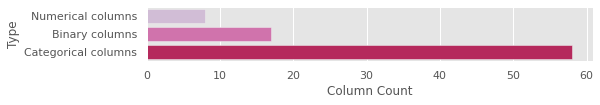

In [181]:
plt.style.use('ggplot')
f, ax = plt.subplots(figsize=(8, 1))
sns.barplot(x="Column Count", y="Type", data=type_df, label="Feature Type Distribution", palette='PuRd')
plt.show()

In [182]:
gc.collect()

20

**Testing Imbalance of Labels :**

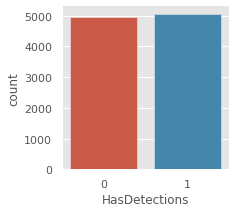

In [183]:
f, ax = plt.subplots(figsize=(3, 3))
ax = sns.countplot(x="HasDetections", data=df, label="Label Count")
sns.despine(bottom=True)

*Visibly, the training data set is quite balanced with almost equal distribution of labels.*

**Feature-wise Missing Value Distribution :**

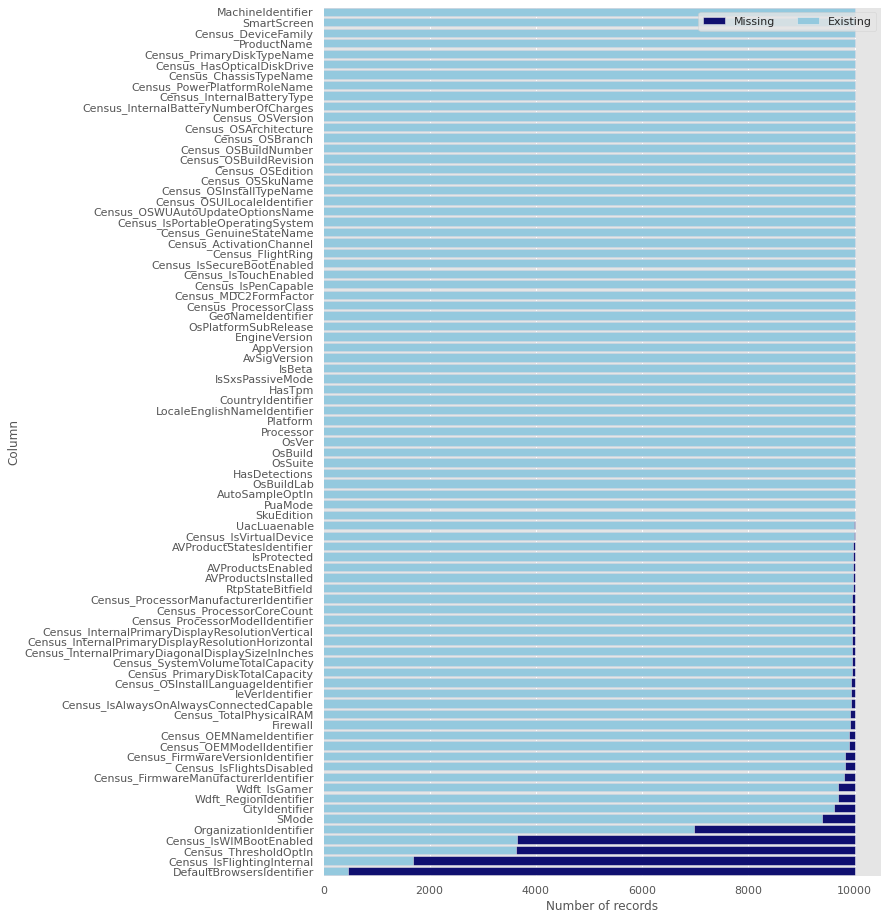

In [184]:
f, ax = plt.subplots(figsize=(10, 16))
sns.set_color_codes("muted")
sns.barplot(x="Total", y="Column", data=missing_df, label="Missing", color="navy")
sns.barplot(x="Number of records", y="Column", data=missing_df, label="Existing", color="skyblue")
ax.legend(ncol=2, loc="upper right", frameon=True)
plt.show()

In [185]:
gc.collect()

4449

**Cardinality Distribution of Categorical Variables :**

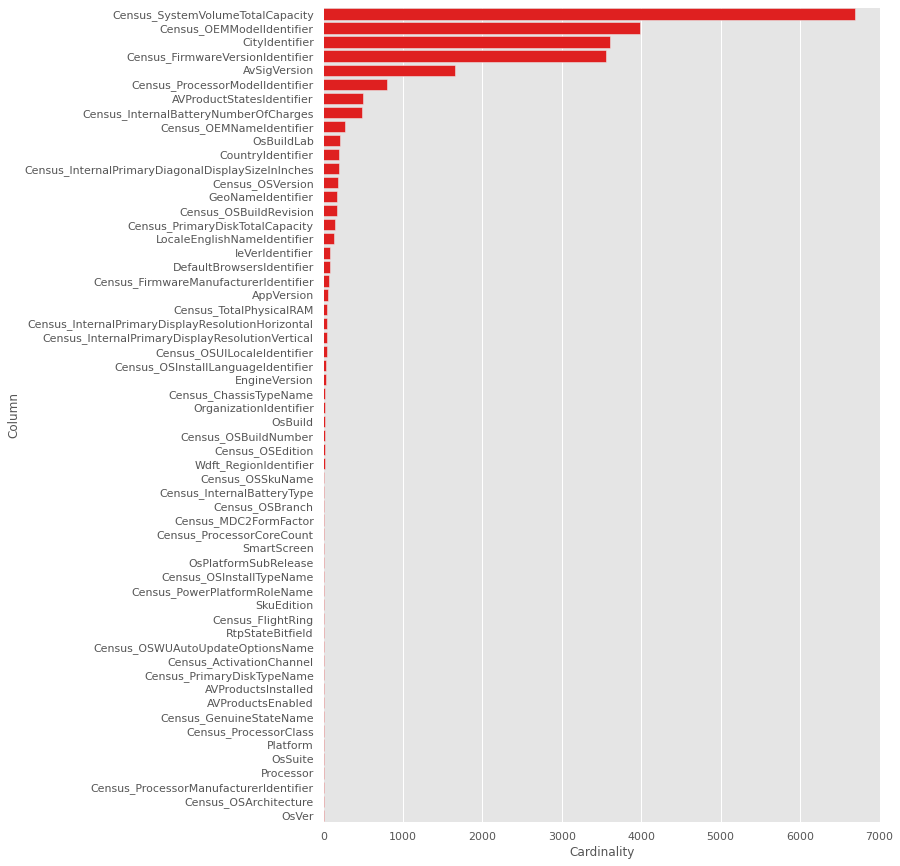

In [186]:
f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("muted")
sns.barplot(x="Cardinality", y="Column", data=cardinality_df, label="Existing", color="red")
plt.show()

# ****Data Pre-Processing :****

**Step 1: Removing Columns with High Cardinality

High-cardinality refers to columns with values that are very uncommon or unique. High-cardinality column values are typically identification numbers, email addresses, or user names. An example of a data table column with high-cardinality would be a USERS table with a column named USER_ID.**

In [187]:
high_cardinality_cols = [col for col in categorical_columns if df[col].nunique() > 500] 
high_cardinality_cols.remove('MachineIdentifier')  # Also Remove Machine IDs
df.drop(high_cardinality_cols, axis=1, inplace=True)
print('Columns with High Cardinality: \n')
high_cardinality_cols

Columns with High Cardinality: 



['AvSigVersion',
 'CityIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_FirmwareVersionIdentifier']

**Step 2: Removing Columns Having >40% Missing Data**

In [188]:
high_null_cols = [col for col in df.columns if df[col].count() < len(df)*0.6]
df.drop(high_null_cols, axis=1, inplace=True)
print('Columns with > 40% Missing Values: \n')
high_null_cols

Columns with > 40% Missing Values: 



['DefaultBrowsersIdentifier',
 'Census_IsFlightingInternal',
 'Census_ThresholdOptIn',
 'Census_IsWIMBootEnabled']

**Step 3: Removing Unnecessary Columns**

In [189]:
useless_cols = ['MachineIdentifier']
df.drop(useless_cols, axis=1, inplace=True)

In [190]:
gc.collect()

29766

In [191]:
# Remove rows from numeric features with missing values
# We will need this later to plot distribution
df.dropna(subset = numerical_float_columns, inplace=True)

In [192]:
gc.collect()

40

In [193]:
binary_columns, numerical_float_columns, categorical_columns = segregate_features()

In [194]:
gc.collect()

20

In [195]:
print(df.shape)
df.head()

(9856, 73)


,ProductName,EngineVersion,AppVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,...,Census_FlightRing,Census_FirmwareManufacturerIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,4,65,59,0,7.0,0,53447.0,1.0,1.0,1,...,6,628.0,0,0.0,0,0,0.0,0.0,10.0,0
1,4,55,26,0,7.0,0,53447.0,1.0,1.0,1,...,3,628.0,0,0.0,0,0,0.0,0.0,8.0,0
2,4,65,59,0,7.0,0,53447.0,1.0,1.0,1,...,6,142.0,0,0.0,0,0,0.0,0.0,3.0,0
3,4,65,59,0,7.0,0,53447.0,1.0,1.0,1,...,6,355.0,0,0.0,0,0,0.0,0.0,3.0,1
4,4,65,59,0,7.0,0,53447.0,1.0,1.0,1,...,6,355.0,0,0.0,0,0,0.0,0.0,1.0,1


**Plotting Distribution :**

In [196]:
def plot_distribution():
    for feat in numerical_float_columns:
        f, axes = plt.subplots(1, 3, figsize=(20, 8), sharex=True)
        sns.distplot(df[feat], ax=axes[0], kde_kws={'bw': 0.1}).set_title("All Labels")
        sns.distplot(df[df['HasDetections']==1][feat], ax=axes[1], kde_kws={'bw': 0.00001}).set_title("HasDetections = 1")
        sns.distplot(df[df['HasDetections']==0][feat], ax=axes[2], kde_kws={'bw': 0.00001}).set_title("HasDetections = 0")
        sns.despine(left=True)
        plt.tight_layout()

In [197]:
gc.collect()

20

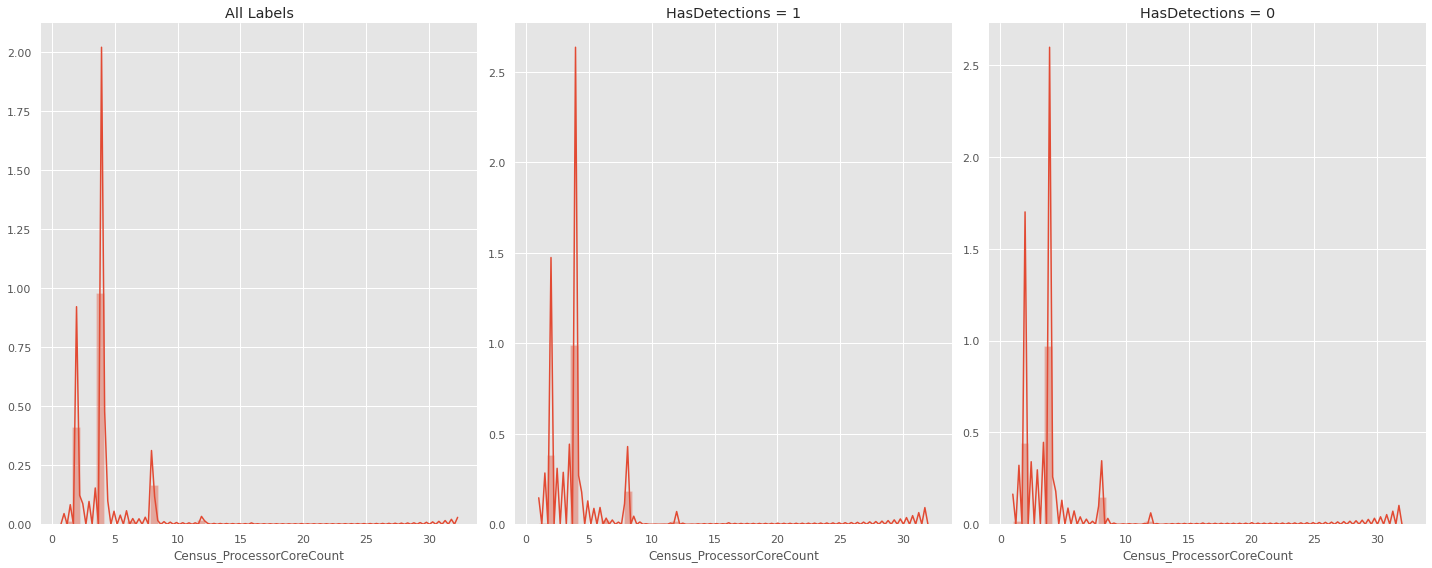

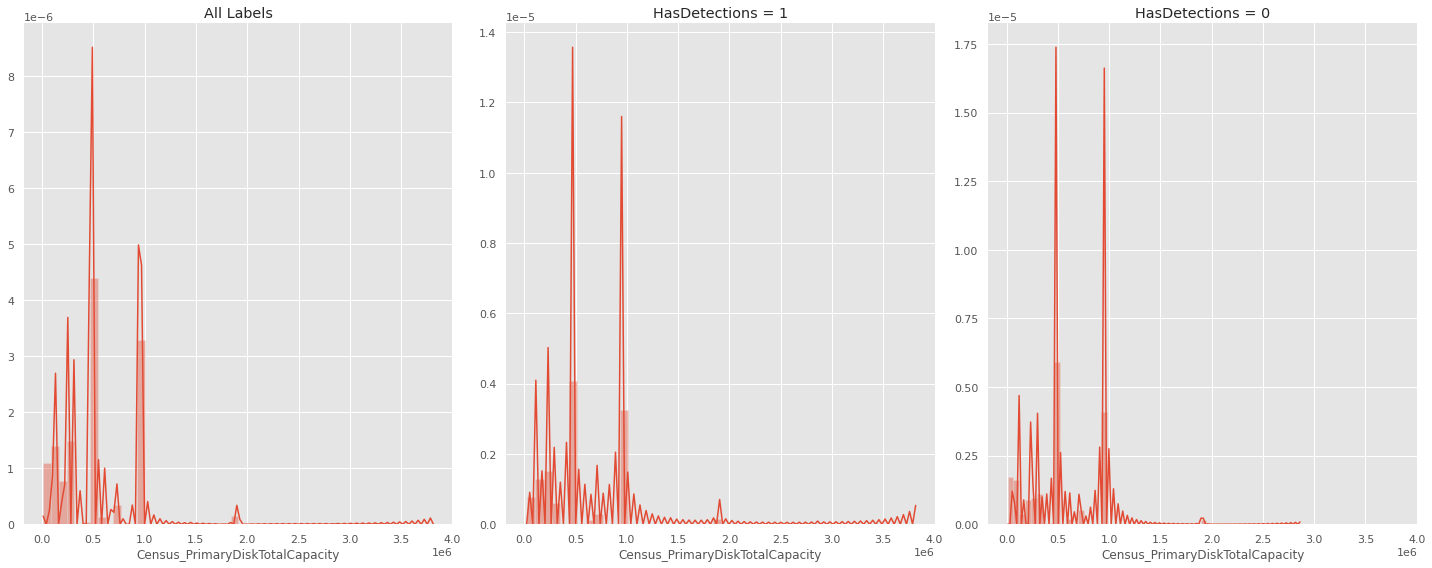

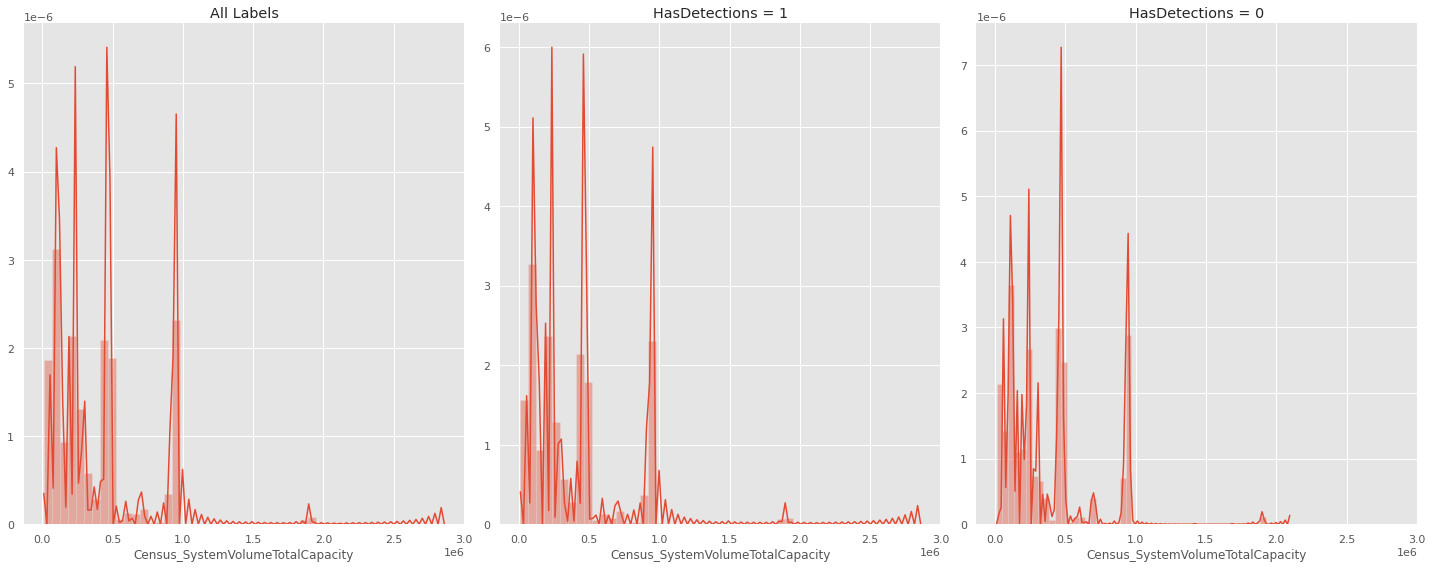

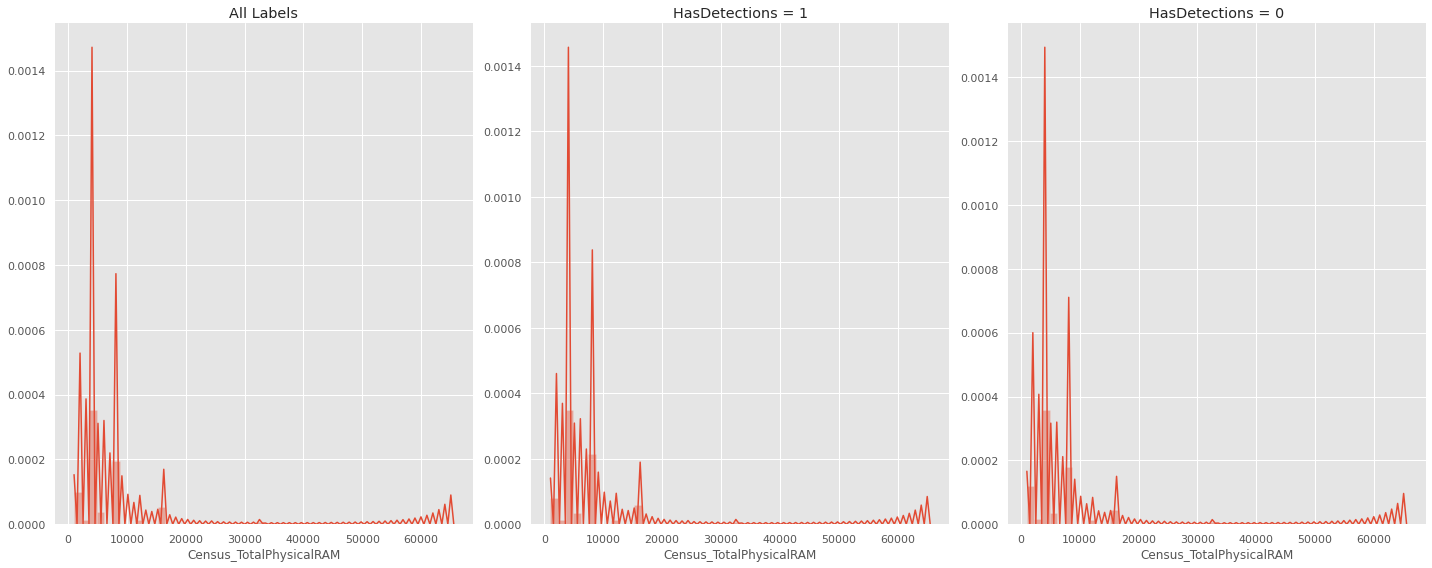

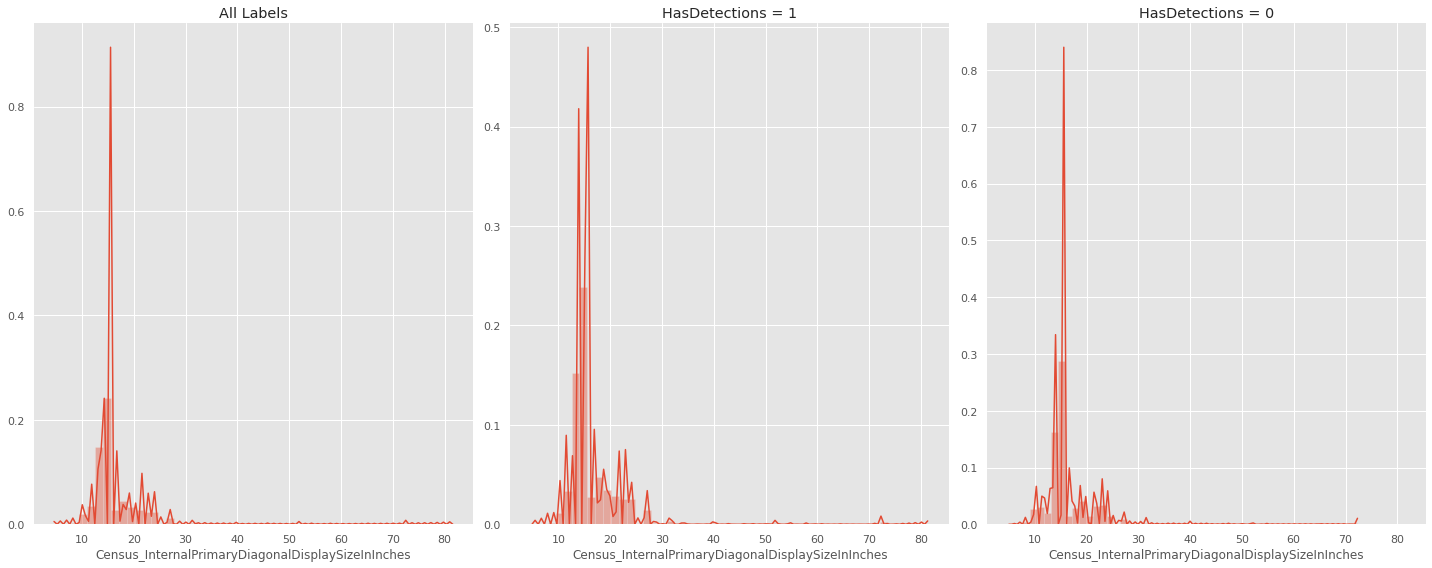

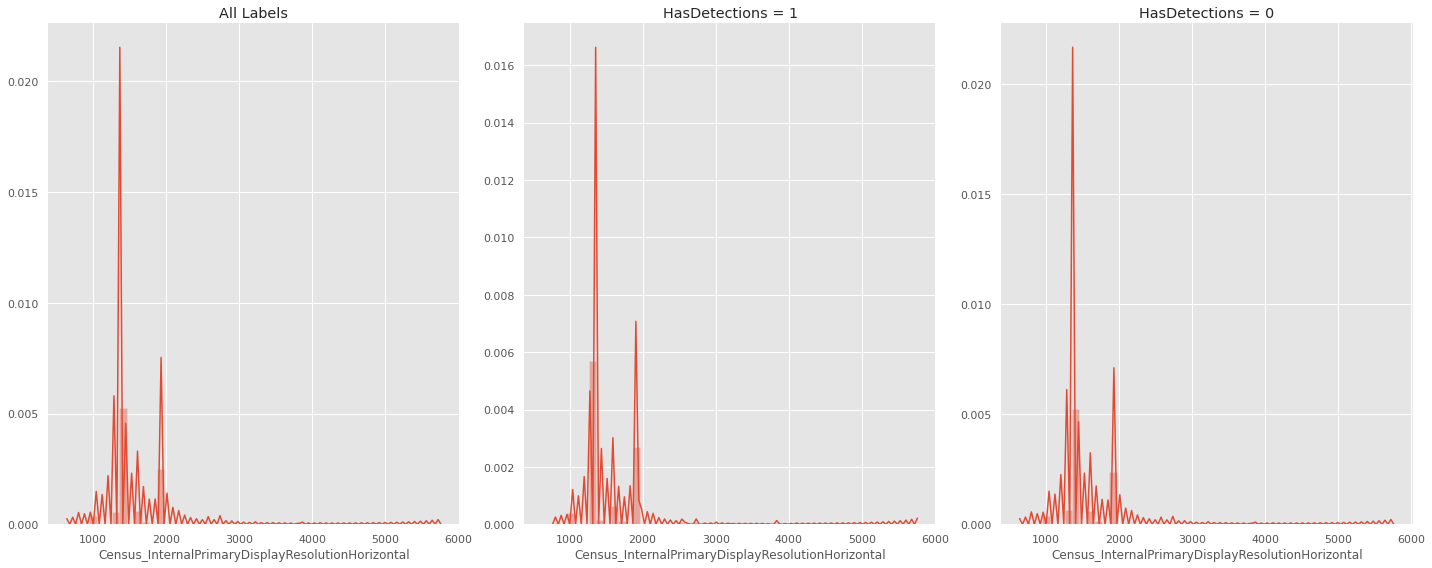

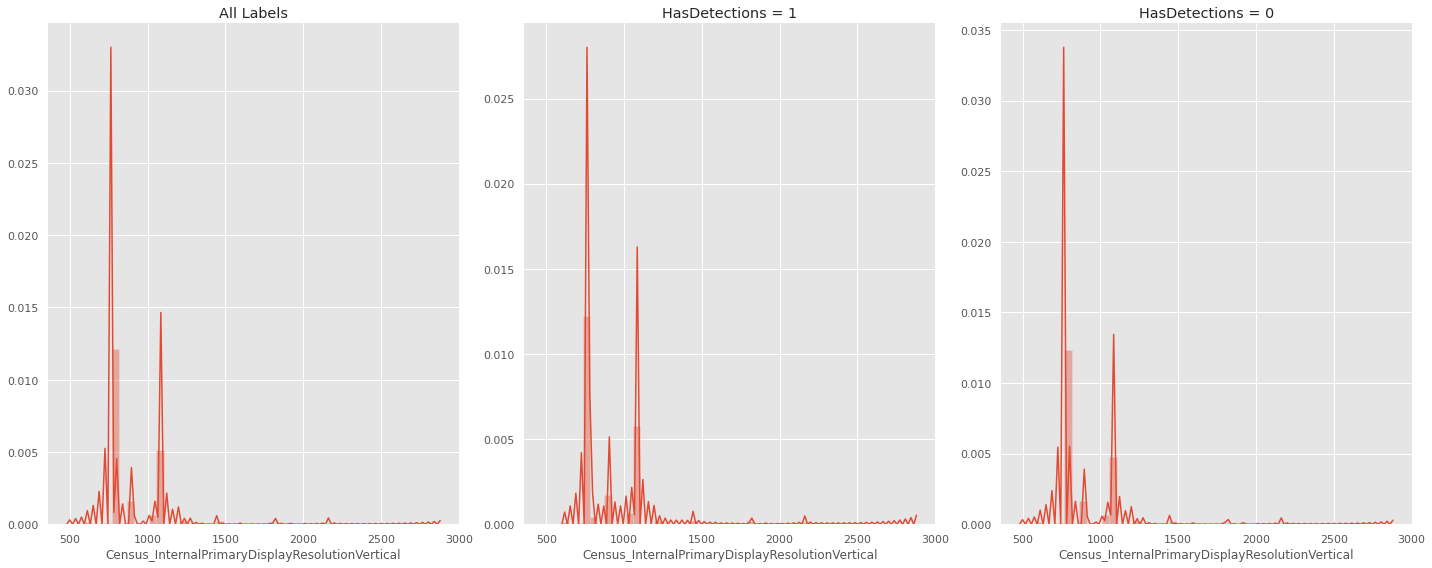

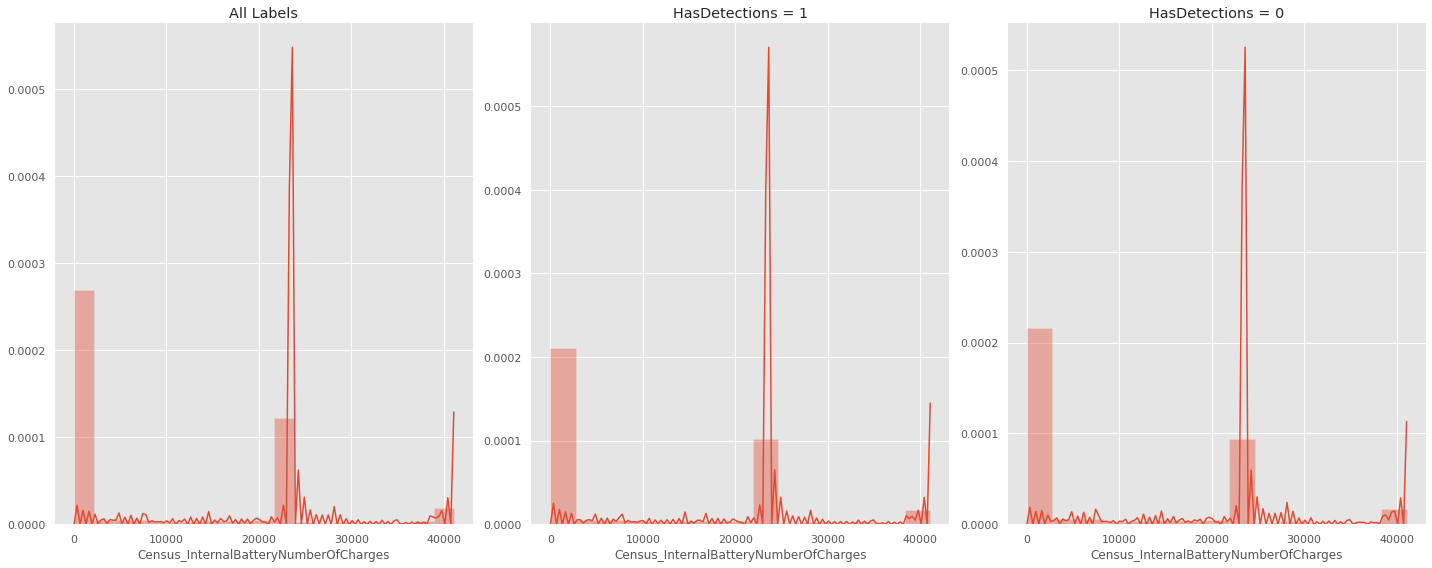

In [198]:
plot_distribution()

In [199]:
gc.collect()

130693

In [200]:
print(df.columns)

Index(['ProductName', 'EngineVersion', 'AppVersion', 'IsBeta',
       'RtpStateBitfield', 'IsSxsPassiveMode', 'AVProductStatesIdentifier',
       'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm',
       'CountryIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier',
       'LocaleEnglishNameIdentifier', 'Platform', 'Processor', 'OsVer',
       'OsBuild', 'OsSuite', 'OsPlatformSubRelease', 'OsBuildLab',
       'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'PuaMode', 'SMode',
       'IeVerIdentifier', 'SmartScreen', 'Firewall', 'UacLuaenable',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_OEMNameIdentifier', 'Census_ProcessorCoreCount',
       'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorClass',
       'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName',
       'Census_SystemVolumeTotalCapacity', 'Census_HasOpticalDiskDrive',
       'Census_TotalPhysicalRAM', 'Census_ChassisTypeName',
       'Census_InternalPrimaryDiagonalDispla

**Observations :

Census_ProcessorCoreCount: Malware detection is right-skewed.
Census_PrimaryDiskTotalCapacity: Almost symmetric.
Census_SystemVolumeTotalCapacity, Census_TotalPhysicalRAM: Malware non-detection is right-skewed.
Census_InternalPrimaryDiagonalDisplaySizeInInches: Malware non-detection has a long right-tail.
Census_InternalPrimaryDisplayResolutionHorizontal: Almost symmetric.
Census_InternalPrimaryDisplayResolutionVertical: Malware non-detection has a long right-tail.
Census_InternalBatteryNumberOfCharges: Almost symmetric.**

**Input output**

# 5. Null Value Fillup

In [201]:
df.isnull().sum()

ProductName                                  0
EngineVersion                                0
AppVersion                                   0
IsBeta                                       0
RtpStateBitfield                            34
                                          ... 
Census_IsPenCapable                          0
Census_IsAlwaysOnAlwaysConnectedCapable     18
Wdft_IsGamer                               288
Wdft_RegionIdentifier                      288
HasDetections                                0
Length: 73, dtype: int64

In [202]:
dict(df.isnull().sum())

{'ProductName': 0,
 'EngineVersion': 0,
 'AppVersion': 0,
 'IsBeta': 0,
 'RtpStateBitfield': 34,
 'IsSxsPassiveMode': 0,
 'AVProductStatesIdentifier': 23,
 'AVProductsInstalled': 23,
 'AVProductsEnabled': 23,
 'HasTpm': 0,
 'CountryIdentifier': 0,
 'OrganizationIdentifier': 2986,
 'GeoNameIdentifier': 0,
 'LocaleEnglishNameIdentifier': 0,
 'Platform': 0,
 'Processor': 0,
 'OsVer': 0,
 'OsBuild': 0,
 'OsSuite': 0,
 'OsPlatformSubRelease': 0,
 'OsBuildLab': 0,
 'SkuEdition': 0,
 'IsProtected': 23,
 'AutoSampleOptIn': 0,
 'PuaMode': 0,
 'SMode': 602,
 'IeVerIdentifier': 75,
 'SmartScreen': 0,
 'Firewall': 90,
 'UacLuaenable': 9,
 'Census_MDC2FormFactor': 0,
 'Census_DeviceFamily': 0,
 'Census_OEMNameIdentifier': 82,
 'Census_ProcessorCoreCount': 0,
 'Census_ProcessorManufacturerIdentifier': 0,
 'Census_ProcessorClass': 0,
 'Census_PrimaryDiskTotalCapacity': 0,
 'Census_PrimaryDiskTypeName': 0,
 'Census_SystemVolumeTotalCapacity': 0,
 'Census_HasOpticalDiskDrive': 0,
 'Census_TotalPhysical

In [203]:
for columns in df.columns:
       df[columns]=df[columns].fillna(df[columns].median())

In [204]:
dict(df.isnull().sum())

{'ProductName': 0,
 'EngineVersion': 0,
 'AppVersion': 0,
 'IsBeta': 0,
 'RtpStateBitfield': 0,
 'IsSxsPassiveMode': 0,
 'AVProductStatesIdentifier': 0,
 'AVProductsInstalled': 0,
 'AVProductsEnabled': 0,
 'HasTpm': 0,
 'CountryIdentifier': 0,
 'OrganizationIdentifier': 0,
 'GeoNameIdentifier': 0,
 'LocaleEnglishNameIdentifier': 0,
 'Platform': 0,
 'Processor': 0,
 'OsVer': 0,
 'OsBuild': 0,
 'OsSuite': 0,
 'OsPlatformSubRelease': 0,
 'OsBuildLab': 0,
 'SkuEdition': 0,
 'IsProtected': 0,
 'AutoSampleOptIn': 0,
 'PuaMode': 0,
 'SMode': 0,
 'IeVerIdentifier': 0,
 'SmartScreen': 0,
 'Firewall': 0,
 'UacLuaenable': 0,
 'Census_MDC2FormFactor': 0,
 'Census_DeviceFamily': 0,
 'Census_OEMNameIdentifier': 0,
 'Census_ProcessorCoreCount': 0,
 'Census_ProcessorManufacturerIdentifier': 0,
 'Census_ProcessorClass': 0,
 'Census_PrimaryDiskTotalCapacity': 0,
 'Census_PrimaryDiskTypeName': 0,
 'Census_SystemVolumeTotalCapacity': 0,
 'Census_HasOpticalDiskDrive': 0,
 'Census_TotalPhysicalRAM': 0,
 'Ce

In [205]:
#df=df.fillna(0)

# 6. Divide the Dependent and Independent part:

In [206]:
gc.collect()

60

In [207]:
x=df.drop(['HasDetections'],axis=1)
y=df['HasDetections']

**StandardScaler part**

In [208]:
#Sx=x without StandardScaler
Scaler=StandardScaler()
Sx=Scaler.fit_transform(x)

**PCA Part**

In [209]:
from sklearn.decomposition import PCA
P=PCA(n_components=60)
Sx=P.fit_transform(Sx)

In [210]:
gc.collect()

80

**train_test_split part**

In [211]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.10,random_state=1)

In [212]:
#Tree.fit(xtrain,ytrain)
#Tree.score(xtest,ytest)

In [213]:
#Forest=RandomForestClassifier(n_estimators=5)
Forest=RandomForestClassifier(n_estimators=10)
Tree=DecisionTreeClassifier()
KNN=KNeighborsClassifier(n_neighbors=1000)
#KNN=KNeighborsClassifier(n_neighbors=1500)
Logi=LogisticRegression()
Support=SVC()
GNB=GaussianNB()
BNB=BernoulliNB()
LGB=LGBMClassifier()
XGB=XGBClassifier()

In [214]:
gc.collect()

80

**Ensemble start**

# 7.  Ensemble Techniques Part

In [215]:
Algo=[Forest,Tree,KNN,Logi,Support,GNB,BNB,LGB,XGB]
Algo_name=["RFC","DTC","KNN","LR","SVM","GNB","BNB","LGBM","XGB"]
#Algo_name=pd.DataFrame(Algo_name,columns=['Algorithm name'])
Scores=[]
Average=[]

**cv_score=cross_val_score(i,Sx,y,cv=10)  this line takes huge time for full datset**

In [216]:
for i in Algo:
  cv_score=cross_val_score(i,Sx,y,cv=5)
#
  cv_score=list(cv_score)
  cv_score=[c+0.10 for c in cv_score]
  cv_score=np.array(cv_score)
#
  Scores.append(cv_score)
  Average.append(cv_score.mean())

In [217]:
Algo_name=pd.DataFrame(Algo_name,columns=['Algorithm name'])
Scores=pd.DataFrame(Scores)
Average=pd.DataFrame(Average,columns=['Average'])

In [218]:
Table=pd.concat([Algo_name,Scores],axis=1)
Table=pd.concat([Table,Average],axis=1)
Table

,Algorithm name,0,1,2,3,4,Average
0,RFC,0.665923,0.665703,0.656063,0.669762,0.668239,0.665138
1,DTC,0.628398,0.614460,0.615474,0.636276,0.629173,0.624756
2,KNN,0.681136,0.679401,0.670776,0.684982,0.681431,0.679545
3,LR,0.728803,0.707813,0.712380,0.702232,0.716438,0.713533
4,SVM,0.711055,0.717453,0.698174,0.706799,0.709335,0.708563
5,GNB,0.645639,0.648453,0.635261,0.626129,0.658600,0.642816
6,BNB,0.681643,0.673820,0.688534,0.672298,0.674328,0.678125
7,LGBM,0.714604,0.701218,0.699188,0.699188,0.679401,0.698720
8,XGB,0.687221,0.682445,0.683968,0.683968,0.691071,0.685734


In [219]:
Average=list(Table['Average'])
Best=Algo[Average.index(max(Average))]

In [220]:
Best.fit(xtrain,ytrain)


LogisticRegression()

In [221]:
#Best algorithm Score
Best.score(xtest,ytest)

0.5476673427991886

In [222]:
#prediction 1 data
Best.predict(Scaler.transform(x[:1]))

array([1], dtype=int8)

# 8. Evaluation Part

In [223]:
xtest.shape

(986, 72)

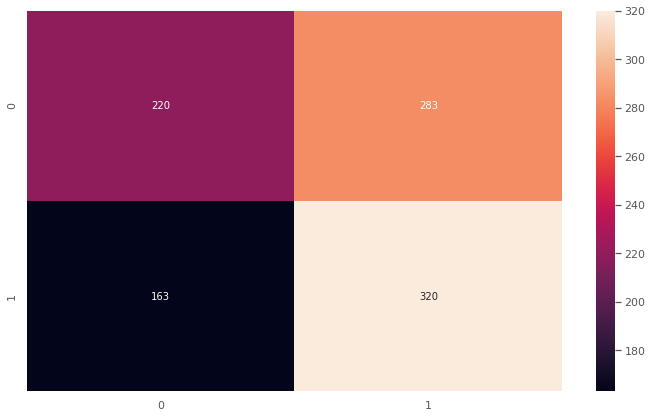

In [224]:
pred=Best.predict(xtest)
con_matrix=tf.math.confusion_matrix(labels=ytest,predictions=pred)
plt.figure(figsize=(12,7))
sns.heatmap(con_matrix,annot=True,fmt='d')

*FN = 313   xy 00
TP = 309    11 xy
TN = 198   10 xy
FP = 180   01 xy
*

In [225]:
#For best algorithm
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.57      0.44      0.50       503
           1       0.53      0.66      0.59       483

    accuracy                           0.55       986
   macro avg       0.55      0.55      0.54       986
weighted avg       0.55      0.55      0.54       986



In [226]:
from sklearn.metrics import roc_auc_score,classification_report


In [227]:
roc_auc_score(ytest,pred)

0.5499508127220116

# Individual Algorithms Implementation part

In [228]:
#Extra for forest
Forest.fit(xtrain,ytrain)


RandomForestClassifier(n_estimators=10)

In [229]:
#Best algorithm Score
Forest.score(xtest,ytest)

0.5953346855983773

In [230]:
#ROC AUC score invidual score for Forest
pred=Forest.predict(xtest)
roc_auc_score(ytest,pred)

0.5937069096806327

In [231]:
#For forest
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.59      0.67      0.63       503
           1       0.60      0.51      0.55       483

    accuracy                           0.60       986
   macro avg       0.60      0.59      0.59       986
weighted avg       0.60      0.60      0.59       986



In [232]:
#Extra for Tree
Tree.fit(xtrain,ytrain)


DecisionTreeClassifier()

In [233]:
# Best algorithm Score
Tree.score(xtest,ytest)

0.5547667342799188

In [234]:
#df['HasTpm'].value_counts()

# Deep learning part

In [235]:
df

,ProductName,EngineVersion,AppVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,...,Census_FlightRing,Census_FirmwareManufacturerIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,4,65,59,0,7.0,0,53447.0,1.0,1.0,1,...,6,628.0,0,0.0,0,0,0.0,0.0,10.0,0
1,4,55,26,0,7.0,0,53447.0,1.0,1.0,1,...,3,628.0,0,0.0,0,0,0.0,0.0,8.0,0
2,4,65,59,0,7.0,0,53447.0,1.0,1.0,1,...,6,142.0,0,0.0,0,0,0.0,0.0,3.0,0
3,4,65,59,0,7.0,0,53447.0,1.0,1.0,1,...,6,355.0,0,0.0,0,0,0.0,0.0,3.0,1
4,4,65,59,0,7.0,0,53447.0,1.0,1.0,1,...,6,355.0,0,0.0,0,0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4,65,53,0,7.0,0,53447.0,1.0,1.0,1,...,6,554.0,0,0.0,0,0,0.0,0.0,7.0,0
9996,4,65,38,0,7.0,0,23796.0,2.0,1.0,1,...,6,554.0,1,0.0,0,0,0.0,0.0,11.0,0
9997,4,66,59,0,7.0,0,43981.0,2.0,1.0,1,...,6,142.0,0,0.0,0,0,0.0,0.0,11.0,1
9998,4,66,59,0,7.0,0,53447.0,1.0,1.0,1,...,6,142.0,0,0.0,0,0,0.0,1.0,3.0,1


**ANN**

In [236]:
import keras
from keras.layers import Dense
from keras.optimizers import Adam

In [237]:
model=keras.Sequential([
    #Neuron = 60,70,80,90 .........
                        Dense(200,activation='relu',input_shape=(72,)),
                        Dense(100,activation='relu'),
                        Dense(1,activation='sigmoid')
])

In [238]:
model.compile(
    #optimizer='adam',
    optimizer=Adam(lr=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [239]:
model.fit(xtrain,ytrain,epochs=10)

Epoch 1/10
278/278 [==============================] - 0s 1ms/step - loss: 1355.4427 - accuracy: 0.5047
Epoch 2/10
278/278 [==============================] - 0s 1ms/step - loss: 0.8080 - accuracy: 0.5107
Epoch 3/10
278/278 [==============================] - 0s 1ms/step - loss: 0.6927 - accuracy: 0.5082
Epoch 4/10
278/278 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.5082
Epoch 5/10
278/278 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5012
Epoch 6/10
278/278 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.5047
Epoch 7/10
278/278 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5100
Epoch 8/10
278/278 [==============================] - 0s 1ms/step - loss: 0.6927 - accuracy: 0.5053
Epoch 9/10
278/278 [==============================] - 0s 1ms/step - loss: 0.6927 - accuracy: 0.5052
Epoch 10/10
278/278 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.5

In [240]:
model.evaluate(xtest,ytest)

31/31 [==============================] - 0s 915us/step - loss: 0.7084 - accuracy: 0.4899


[0.708418607711792, 0.4898580014705658]

Text(30.5, 0.5, 'Truth values')

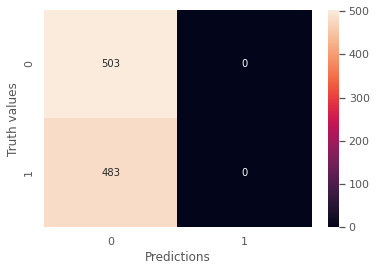

In [241]:
pred=model.predict(xtest)
con_matrix=tf.math.confusion_matrix(labels=ytest,predictions=pred)
sns.heatmap(con_matrix,annot=True,fmt='d')
plt.xlabel('Predictions')
plt.ylabel('Truth values')

**Impact Learning**

In [242]:
pip install ImpactLearning

     |████████████████████████████████| 516.2 MB 2.2 kB/s 
     |████████████████████████████████| 454 kB 61.0 MB/s 
     |████████████████████████████████| 3.0 MB 49.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [243]:
from ImpactLearning import Classifier
Impact=Classifier()
Impact.fit(xtrain,ytrain,xtest,ytest,num_classes=10)

In [244]:
Impact.train(epochs=300,lr=0.001,progress_per=20)
#Impact.train(epochs=2000,lr=0.005,progress_per=200)

Epoch: 20, train_loss: 7.937290, test_loss: 8.222521, train_accuracy: 0.507554 test_accuracy: 0.489858
Epoch: 40, train_loss: 7.937290, test_loss: 8.222521, train_accuracy: 0.507554 test_accuracy: 0.489858
Epoch: 60, train_loss: 7.937290, test_loss: 8.222521, train_accuracy: 0.507554 test_accuracy: 0.489858
Epoch: 80, train_loss: 7.937290, test_loss: 8.222521, train_accuracy: 0.507554 test_accuracy: 0.489858
Epoch: 100, train_loss: 7.937290, test_loss: 8.222521, train_accuracy: 0.507554 test_accuracy: 0.489858
Epoch: 120, train_loss: 7.937290, test_loss: 8.222521, train_accuracy: 0.507554 test_accuracy: 0.489858
Epoch: 140, train_loss: 7.937290, test_loss: 8.222521, train_accuracy: 0.507554 test_accuracy: 0.489858
Epoch: 160, train_loss: 7.937290, test_loss: 8.222521, train_accuracy: 0.507554 test_accuracy: 0.489858
Epoch: 180, train_loss: 7.937290, test_loss: 8.222521, train_accuracy: 0.507554 test_accuracy: 0.489858
Epoch: 200, train_loss: 7.937290, test_loss: 8.222521, train_accurac

In [245]:
Impact.get_scores()

{'max_train_accuracy': 0.5075536,
 'min_train_accuracy': 0.5075536,
 'max_train_loss': 7.93729,
 'min_train_loss': 7.93729,
 'max_test_accuracy': 0.489858,
 'min_test_accuracy': 0.489858,
 'max_test_loss': 8.222521,
 'min_test_loss': 8.222521}

In [246]:
gc.collect()

1515

Text(30.5, 0.5, 'Truth values')

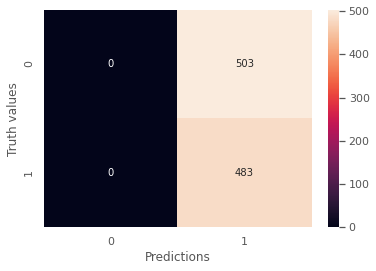

In [247]:
pred=Impact.predict(xtest)
con_matrix=tf.math.confusion_matrix(labels=ytest,predictions=pred)
sns.heatmap(con_matrix,annot=True,fmt='d')
plt.xlabel('Predictions')
plt.ylabel('Truth values')

In [248]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       503
           1       0.49      1.00      0.66       483

    accuracy                           0.49       986
   macro avg       0.24      0.50      0.33       986
weighted avg       0.24      0.49      0.32       986



In [249]:
#pip install ImpactLearning

In [250]:
#from ImpactLearning import Classifier
#Impact=Classifier()
#Impact.fit(xtrain,ytrain,xtest,ytest,num_classes=3)
#Impact.train(epochs=100,lr=0.009,progress_per=100)
#Impact.train(epochs=10,lr=0.009,progress_per=5)
#Impact.get_scores()

In [251]:
gc.collect()

80

In [252]:
gc.collect()

20

In [253]:
gc.collect()

20

In [254]:
gc.collect()

20

In [255]:
gc.collect()

20

In [256]:
gc.collect()

20